### Gradient Descend Algorithm
Application of a Gradient Descend Algorithm for the tuning of a PID Controller Parameters

![title](gd.jpg)

In [7]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt

'''Your job is to complete the twiddle function. I have written a
   cost function for your that attempts to minimize percent overshoot.
   Feel free to modify the cost function! Just remember that the cost
   function must return a single scalar value.
'''

def ydot(y, t, dt, r, p):
    ''' ydot returns the next state of the quadrotor as a function of
    the current state and control inputs.
    Parameters:
    -----------
    y = augmented state vector (7 element list)
    t = time, (sec)
    dt = time-step, (sec)
    r = controller setpoint, (m)
    p = list of PID gains = [kp, ki, kd]
    '''
    # Model states
    y1 = y[0] # altitude, (m)
    y2 = y[1] # speed, (m/s)
    y3 = y[2] # last error, (m)
    y4 = y[3] # integral of error, (m*sec)
    y5 = y[4] # proportional effort term, (m/s/s)
    y6 = y[5] # integral effort term, (m/s/s)
    y7 = y[6] # derivative effort term, (m/s/s)

    # Current position error, (m)
    e = r - y1

    # Control Effort (i.e., net motor thrust)
    Kp = p[0]
    Ki = p[1]
    Kd = p[2]
    up = Kp*e # proportional control effort
    ui = Ki*(e*dt + y4) # integral control effort
    ud = Kd*(e - y3)/dt # derivative control effort
    u = up + ui + ud # total control effort

    # Actuator limits
    if u > umax:
        u = umax # max possible output
    elif u < 0:
        u = 0 # the quadrotor's motors cannot run in reverse

    ### State derivatives
    # if altitude = 0
    if (y1 <= 0.):
    # if control input, u <= gravity, vehicle stays at rest on the ground
    # this prevents quadrotor from "falling" through the ground if thrust is
    # too small.
        if u <= np.absolute(g*m/c):
            y1dot = 0.
            y2dot = 0.
        else:
            # if u > gravity and quadrotor accelerates upwards
            y1dot = y2
            y2dot = g + c/m*u - 0.75*y2
    else: # otherwise quadrotor is already in the air
        y1dot = y2
        y2dot = g + c/m*u - 0.75*y2

    # Calculate new state
    y1 += y1dot*dt
    y2 += y2dot*dt
    y3 = e
    y4 += e*dt
    y5 = up
    y6 = ui
    y7 = ud
    return [y1, y2, y3, y4, y5, y6, y7]

In [8]:
def hover(p):
    ''' This function simulates the quadrotor's
        motion in response to a step change in the altitude setpoint.
        The states as a function of time are stored in the np.array, soln.
    '''
    # Inital conditions
    y = [0, 0, 0, 0, 0, 0, 0]
        #y[0] = initial altitude, (m)
        #y[1] = initial speed, (m/s)
        #y[2] = current error, (m)
        #y[3] = integral of error, (m*sec)
        #y[4] = proportional control
        #y[5] = integral control
        #y[6] = derivative control
    # Initialize array to store values
    soln = np.zeros((len(time),len(y)))

    j = 0 # dummy counter
    for t in time:
        y = ydot(y,t,dt,r,p)
        soln[j,:] = y
        j += 1
    return soln

In [9]:
def cost_fun(soln):
    '''
    This is the function that Twiddle is trying to optimize.
    FEEL FREE TO WRITE YOUR OWN COST-FUNCTION!!!
    Here I have it trying to minimize overshoot.
    '''
    y0 = soln[:,0] #altitude
    rise_time_index =  np.argmax(y0>r)
    RT = time[rise_time_index]

    OS = (np.max(y0) - r)/r*100
    OS_pen = OS
    if OS < 0:
        OS = 0
        OS_pen = 100
    #return OS_pen**2 + RT**2
    return OS_pen**2

In [10]:
def twiddle(tol=0.05):
    # initial gain estimates
    p = [2, 2, 2]
    dp = [0.10, 0.10, 0.10]
    #robot = make_robot()
    #x_trajectory, y_trajectory, best_err = run(robot, p)
    soln = hover(p)
    best_cost = cost_fun(soln)

    # TODO: Complete the Twiddle ALgorithm
    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_cost))
        for i in range(len(p)):
            p[i] += dp[i]
            # Can't have negative gains
            if p[i] < 0:
                p[i] = 0
            soln = hover(p)
            cost = cost_fun(soln)

            if cost < best_cost:
                best_cost = cost
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                # Can't have negative gains
                if p[i] < 0:
                    p[i] = 0
                soln = hover(p)
                cost = cost_fun(soln)

                if cost < best_cost:
                    best_cost = cost
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    # Can't have negative gains
                    if p[i] < 0:
                        p[i] = 0
                    dp[i] *= 0.9
        it += 1
    #######################################
    return p

### Drone Simulation

In [11]:
# Simulation parameters
N = 500 # number of simultion points
t0 = 0  # starting time, (sec)
tf = 30 # end time, (sec)
time = np.linspace(t0, tf, N)
dt = time[1] - time[0] # delta t, (sec)
r = 10 # altitude setpoint, (m)

# Model parameters
g = -9.81 # gravity, m/s/s
m =  1.54 # quadrotor mass, kg
c = 10.   # electro-mechanical transmission constant
umax = 5.0 # max controller output, (m/s/s)

p = twiddle()
print(p)
soln = hover(p)

Iteration 0, best error = 1512.7482851742875
Iteration 1, best error = 1328.603631778417
Iteration 2, best error = 1144.8455886580318
Iteration 3, best error = 961.5430897948886
Iteration 4, best error = 783.1182469340695
Iteration 5, best error = 612.6172237006944
Iteration 6, best error = 452.43794261727203
Iteration 7, best error = 305.7984472011611
Iteration 8, best error = 175.35951967585999
Iteration 9, best error = 76.21076989239549
Iteration 10, best error = 18.218737669978054
Iteration 11, best error = 18.218737669978054
Iteration 12, best error = 18.160375187752962
Iteration 13, best error = 0.04143894039440686
Iteration 14, best error = 0.04143894039440686
Iteration 15, best error = 0.04143894039440686
Iteration 16, best error = 0.04143894039440686
Iteration 17, best error = 0.04143894039440686
Iteration 18, best error = 0.04143894039440686
Iteration 19, best error = 0.04143894039440686
Iteration 20, best error = 0.04143894039440686
Iteration 21, best error = 0.0414389403944

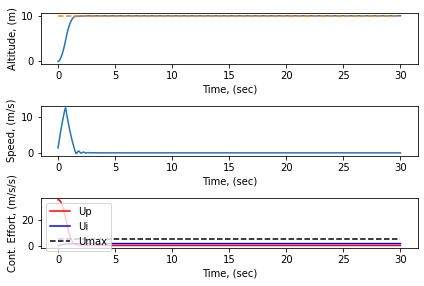

In [12]:
# Plot results
SP = np.ones_like(time)*r # altitude set point
UMAX = np.ones_like(time)*umax
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(time, soln[:,0],time,SP,'--')
ax1.set_xlabel('Time, (sec)')
ax1.set_ylabel('Altitude, (m)')
ax2 = fig.add_subplot(312)
ax2.plot(time, soln[:,1])
ax2.set_xlabel('Time, (sec)')
ax2.set_ylabel('Speed, (m/s)')

ax3 = fig.add_subplot(313)
ax3.plot(time, soln[:,4], '-r', label="Up")
ax3.plot(time, soln[:,5], '-b', label="Ui")
ax3.plot(time, UMAX,'--k', label="Umax")
ax3.set_xlabel('Time, (sec)')
ax3.set_ylabel('Cont. Effort, (m/s/s)')
ax3.legend(loc='upper left')
plt.tight_layout()
plt.show()